# Data set generation
<i>Authors: Markus Viljanen </i>

This notebook explains how we generate the data sets used in the MCF and Regression tutorials. The data sets are based on a simple stochastic process. We first give a mathematical definition for the stochastic process, and then visualize the generated data sets.

<p><b> Table of contents </b></p>
<ul>
  <li><a href='#imports'>Imports</a></li>
  <li><a href='#datageneration'>Data set generation</a></li>
  <li><a href='#data1'>Data set 1</a></li>
  <li><a href='#data2'>Data set 2</a></li>
  <li><a href='#data3'>Data set 3</a></li>
  <li><a href='#data4'>Data set 4</a></li>
  <li><a href='#conclusion'>Conclusion</a></li>
</ul>

<a id='imports'></a>

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
from data_operations import transform_data, plot_data, plot_datas

<a id='datageneration'></a>

## Data set generation

> It is safe to skip this section if the math is difficult.


We programmed a simple function that generates a censored data set of purchases and sessions with a given number of players. We model each player as a stochastic process where the player makes purchases and sessions at random until they churn out. For simplicity we give the process definition for purchases, but the sessions are defined analogously. We denote the churn time as a random variable $T$, the purchase times as random variables $T_1,T_2,…,T_m$. The number of purchases $m$ is a random variable implied by the underlying process. Denote the total number of purchases at time $t$ as a random variable $N(t)$.

The process $N(t)$ is then defined by two rates: the churn rate $\mu$ and the purchase rate $\lambda$. We assume that the rates are constant when we generate the data. The churn rate is the rate at which players churn out of the game and the purchase rate is the rate at which they purchase if they have not yet churned out:
$$ \mu=\text{lim}_{dt \rightarrow 0} \frac{P(t < T < t + dt | T>t)}{dt} $$
$$\lambda=\text{lim}_{\delta t \rightarrow 0} \frac{P(N(t + dt) - N(t) | T>t)}{dt} $$
This implies that the churn time $T \sim \text{Exp}(\mu)$ is exponentially distributed, and the time between purchases $dT_k=T_{k+1} - T_k \sim \text{Exp}(\lambda)$ is also exponentially distributed. The censoring time $S \sim \text{Unif}(0,c)$ is generated from the uniform distribution. 

The marginal purchase rate is the rate at which customers purchase. It is affect by both the purchase rate and the churn rate, as it decreases from the original purchase rate toward zero as customers churn out. The probability of churning out after time $t$ is given by the survival function $P(T>t)$. The marginal purchase rate is then given by:
$$\gamma(t)=\text{lim}_{dt \rightarrow 0} \frac{P(N(t + dt) - N(t) | T>t) P(T>t)}{dt}$$
The expected number of purchases at time $t$ is given as the integral of the marginal purchase rate:
$$E[N(t)] = \int_0^\infty \gamma(t) dt$$

This process can be extended to have a real-valued variable associated to each purchase. Every purchase has an underlying amount $C_1,C_2,…,C_m$, also called 'cost', which we assume to be an i.i.d. random variable sampled from an arbitrary distribution. Denote the total cost at time $t$ as a random variable $C(t)=\sum_{k=1}^{N(t)}C_k$. If the cost distribution and the process are in fact independent, the expected cost at time $t$ is given by:
$$E[C(t)] = E[C_k]E[N(t)]$$

We therefore generate the data as follows. For each player $i$ we sample a churn time $t_i \sim \text{Exp}(\mu)$ and a censoring time $s_i\sim \text{Unif}(0,c)$. We then obtain purchase times by sampling the time of next purchase until we reach the churn time or the censoring time. Initially, we define $t_{i,0} = 0$, then iterate the next purchase time $t_{i,j} = t_{i,j-1} + dt_{i,j}$ by sampling $dt_{i,j} \sim \text{Exp}(\lambda)$ while $t_{i,j} < \text{max}(t_i, s_i) $. At each purchase time we also sample the cost $c_{i,j}$. The generated data set is stored as tuples of purchase times $\{(i, t_{i,j}, 1, c_{i,j})\}_{i=1,..,n, j=1,...,m_i}$ and censoring times $\{(i, s_i, 0, 0)\}_{i=1,..,n}$. The third element (0/1) denotes whether a given time is an event time (1) or censoring time (0). The churn times are unknown in the final data set.


<img src="https://media.springernature.com/w306/springer-static/cover-hires/book/978-0-387-69810-6" width="100"/> 
> A good reference for learning about recurrent event stochastic processes is the book "The Statistical Analysis of Recurrent Events" by Richard J. Cook and Jerald F. Lawless (https://link.springer.com/book/10.1007/978-0-387-69810-6).


In [3]:
# Players are modelled as a stochastic process with two types of events (session/purchase) and a hidden terminal event (churn):
#
#     Sessions: a recurrent event homogeneous Poisson process (play_rate) while not churned
#     Purchases: a recurrent event homogeneous Poisson process (purchase_rate) while not churned
#     Churn: a single event homogeneous Poisson process (quit_rate)
#
#     Sessions have an arbitrary duration distribution (playtime_dist) 
#     Purchases have an arbitrary amount distribution (purchase_dist)
#
#     A number of players (n) is sampled and uniformly censored up to maximum follow-up (cens).
#
class MarkovRecurrentTerminal(object):

    def __init__(self, play_rate, purchase_rate, quit_rate, playtime_dist, purchase_dist):
        self.play_rate = play_rate
        self.purchase_rate = purchase_rate
        self.quit_rate = quit_rate
        self.playtime_dist = playtime_dist
        self.purchase_dist = purchase_dist

    def __str__(self):
        return "Play rate: %s\nPurchase rate: %s\nQuit rate: %s" % (self.play_rate, self.purchase_rate, self.quit_rate)

    def Sample(self, n, cens):
        T = []
        for i in range(1, n+1):
            Ti = []
            tmax = stats.uniform.rvs() * cens
            tiq = stats.expon.rvs() / self.quit_rate
            tij = stats.expon.rvs() / self.play_rate
            while tij <= tmax and tij < tiq:
                Ti.append((tij, 1, 0, self.playtime_dist.rvs()))
                tij = tij + stats.expon.rvs() / self.play_rate
            tij = stats.expon.rvs() / self.purchase_rate
            while tij <= tmax and tij < tiq:
                Ti.append((tij, 1, 1, self.purchase_dist.rvs()))
                tij = tij + stats.expon.rvs() / self.purchase_rate
            Ti.append((tmax, 0, 0, 0))
            T.extend([(i, tij, event, type, cost) for tij, event, type, cost in Ti])
        return pd.DataFrame(T, columns=['Sample', 'Time', 'Event', 'Type', 'Cost'])


It is possible to generate many data sets with different purchase, sessions or churn rates. One could have different cohorts, for example. These data sets can then be combined to a single data set. However, the sample indicator ('Sample') needs to be re-mapped so that in the final data set the samples run $i=1,...,n$. This function does that:

In [4]:
def combine_datas(*datas):
    new_datas = []
    index_samples = 1
    for data in datas:
        samples = data['Sample'].unique()
        samples_to = range(index_samples, index_samples + len(samples))
        data['Sample'] = data['Sample'].map(dict(zip(samples, samples_to)))
        index_samples += len(samples)
        new_datas.append(data)
    return pd.concat(new_datas, axis=0, ignore_index=True)

Because the purchase rate $\lambda$ and the churn rate $\mu$ are constant, it is possible to analytically derive the expected number of purchases over time. The marginal purchase rate can be written $\gamma(t)=\text{lim}_{dt \rightarrow 0} P(N(t + dt) - N(t) | T>t) P(T>t) / dt = \lambda \text{exp}(-\mu t)$, and the expected number of purchases is therefore: 

$$E[N(t)] = \int_0^\infty \gamma(t) dt = \frac{\lambda}{\mu}(1 - \text{exp}(-\mu t))$$

We can code this and the expected purchase amount (LTV or Lifetime Value) as:

In [5]:
E_N = lambda T, rate, churn_rate : rate / churn_rate * (1 - np.exp(-churn_rate*T))
LTV = lambda T, rate, churn_rate, mean : mean * rate / churn_rate * (1 - np.exp(-churn_rate*T))

The number of purchases and sessions were generated by setting reasonably realistic parameter values:
* The maximum follow-up $180$ days
* The session rate $\lambda_1=0.1$ per day
* The purchase rate to $\lambda_2=0.004$ per day
* The churn rate to $\mu=0.02$ per day. 

These values imply that a player eventually ($t \rightarrow \infty$) has an expected number of $\lambda_1 / \mu = 5$ sessions and $\lambda_2 / \mu = 0.2$ purchases.

Expected number of sessions 5.00, purchases 0.20


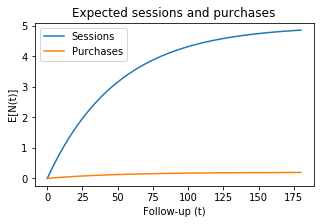

In [6]:
max_date, play_rate, purchase_rate, churn_rate = 180, 0.1, 0.004, 0.02

x = np.linspace(0,180,181)
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(x, E_N(x, play_rate, churn_rate), label='Sessions')
ax.plot(x, E_N(x, purchase_rate, churn_rate), label='Purchases')
ax.set_title('Expected sessions and purchases')
ax.set_ylabel('E[N(t)]')
ax.set_xlabel('Follow-up (t)')
ax.legend()
print "Expected number of sessions %.2f, purchases %.2f" % (play_rate/churn_rate, purchase_rate/churn_rate)

The session duration is exponentially distributed with a rate parameter $0.25$, so that the expected duration is 0.25 hours (or 15 minutes).

Session duration mean 0.25, std 0.25


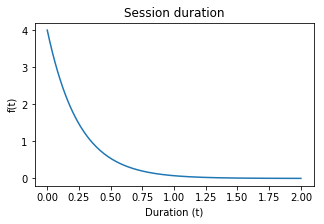

In [7]:
playtime_dist = stats.expon(scale=0.25)

x = np.linspace(0,2,201)
y = playtime_dist.pdf(x)
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(x, y)
ax.set_title('Session duration')
ax.set_ylabel('f(t)')
ax.set_xlabel('Duration (t)')
print "Session duration mean %.2f, std %.2f" % (playtime_dist.mean(), playtime_dist.std())

The purchase amount is a custom discrete distribution with values 1€, 4€, 10€, 20€ with the corresponding probabilities 80\%, 15\%, 4\%, 1\%, so that the expected purchase amount is 2€ with a large variance:

Purchase amount 2.00, std 2.68


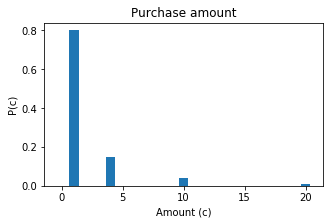

In [8]:
purchase_dist = stats.rv_discrete(values=((1, 4, 10, 20), (0.80, 0.15, 0.04, 0.01)))

x = np.linspace(0,20,21)
y = purchase_dist.pmf(x)
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.bar(x, y)
ax.set_title('Purchase amount')
ax.set_ylabel('P(c)')
ax.set_xlabel('Amount (c)')
print "Purchase amount %.2f, std %.2f" % (purchase_dist.mean(), purchase_dist.std())

<a id='data1'></a>

## Data set 1


The first data set is a simple population of players with the session rate $\lambda_1=0.1$, the purchase rate $\lambda_2=0.004$, and the churn rate $\mu=0.02$. The data set includes two types of events: sessions (Type=0) and purchases (Type=1). The event times are denoted by (Event=1) and the censoring time by (Event=0). We therefore split the generated data set into a data set for sessions and another data set for purchases.

In [9]:
process = MarkovRecurrentTerminal(play_rate, purchase_rate, churn_rate, playtime_dist, purchase_dist)
data = process.Sample(100, max_date)
data_sessions = data[(data['Type'] == 0) | (data['Event'] == 0)]
data_purchases = data[(data['Type'] == 1) | (data['Event'] == 0)]

The data set of sessions looks like this:

In [10]:
data_sessions[['Sample', 'Time', 'Event', 'Cost']].head()

,Sample,Time,Event,Cost
0,1,136.177888,0,0.000000
1,2,16.412515,1,0.231831
2,2,107.428863,0,0.000000
3,3,0.062728,1,0.253390
4,3,2.101880,1,0.154260


And the data set of purchases like this:

In [11]:
data_purchases[['Sample', 'Time', 'Event', 'Cost']].head()

,Sample,Time,Event,Cost
0,1,136.177888,0,0.0
2,2,107.428863,0,0.0
7,3,89.585053,0,0.0
8,4,36.305943,0,0.0
11,5,22.274569,1,4.0


The data set can be visualized with a simple plotting method, which first requires transforming the data set to a counting process format:

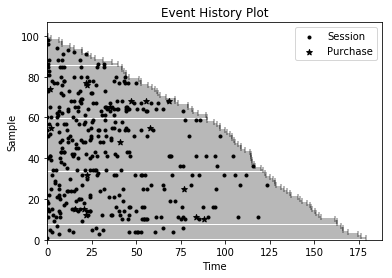

In [12]:
df_sessions = transform_data(data_sessions)
df_purchases = transform_data(data_purchases)

fig, ax = plt.subplots(1, 1)
plot_data(df_sessions, ax=ax, marker='.', plot_costs=False, label='Session', alpha=0.2)
plot_data(df_purchases, ax=ax, marker='*', plot_costs=False, label='Purchase', alpha=0.2)

The different follow-up times result from different acquistion dates. Players start playing at different days, and the resulting follow-up time is the duration between these days and the day when the data was gathered. For example, if the players have started between 01-01-2020 and 30-06-2020 and the data was gathered at 30-06-2020 (180 days of follow-up), it would look like this:

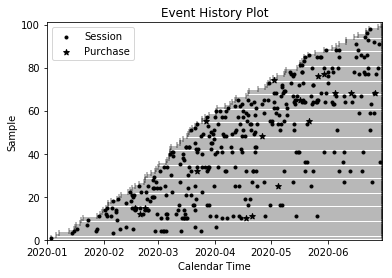

In [13]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Convert follow-up times to hypothetical calendar times
def convert_calendar(data, start, end):
    followup = data.loc[data['dY'] == -1, ['Sample', 'Time']]#.rename(columns={'Time': 'Time.end'})
    data = data.merge(followup, on='Sample', suffixes=('', '.end'))
    time_delta = pd.to_timedelta(data['Time.end'] - data['Time'], 'D')
    data['Time'] = end - time_delta
    return(data)

start, end = pd.Timestamp('2020-01-01'), pd.Timestamp('2020-06-30')
df_sessions = convert_calendar(df_sessions, start, end)
df_purchases = convert_calendar(df_purchases, start, end)

fig, ax = plt.subplots(1, 1)
ax1 = plot_data(df_sessions, ax=ax, marker='.', plot_costs=False, label='Session', alpha=0.2, update_limits=False, order_followup=False)
ax2 = plot_data(df_purchases, ax=ax, marker='*', plot_costs=False, label='Purchase', alpha=0.2, update_limits=False, order_followup=False)
ax1.set_xlabel('Calendar Time')
ax2.set_xlabel('Calendar Time')
ax1.set_ylim(0, 101)
ax2.set_ylim(0, 101)
ax1.set_xlim(start, end)
ax2.set_xlim(start, end)
plt.show()


We save the sessions to 'sessions.csv' and purchases to 'purchases.csv'.

In [14]:
data_sessions[['Sample', 'Time', 'Event', 'Cost']].to_csv('tutorial/sessions.csv', index=False)
data_purchases[['Sample', 'Time', 'Event', 'Cost']].to_csv('tutorial/purchases.csv', index=False)

<a id='data2'></a>

## Data set 2

In the second data set, we assume two platforms (ios, android) have different purchase and churn rates. Relative to the original data set with $\lambda=0.004$ and $\mu=0.02$, let the ios platform have a 50\% larger purchase rate and the android platform have a 100\% larger churn rate. This defines the following cohorts:
* ios: $\lambda=0.004*1.5$ and $\mu=0.02$ (Expected number of purchases $\lambda / \mu = 0.30$)
* android: $\lambda=0.004$ and $\mu=0.02*2.0$ (Expected number of purchases $\lambda / \mu = 0.10$)

We generate the data sets separately and combine them to a single data set with the 'Platform' identifier:

In [15]:
process = MarkovRecurrentTerminal(play_rate, purchase_rate*1.5, churn_rate, playtime_dist, purchase_dist)
data1 = process.Sample(100, max_date)
data1['Platform'] = 'ios'

process = MarkovRecurrentTerminal(play_rate, purchase_rate, churn_rate*2.0, playtime_dist, purchase_dist)
data2 = process.Sample(100, max_date)
data2['Platform'] = 'android'

data = combine_datas(data1, data2)
data_purchases = data[(data['Type'] == 1) | (data['Event'] == 0)]

print "Expected number of purchases ios %.2f, android %.2f" % (purchase_rate*1.5/churn_rate, purchase_rate/(churn_rate*2.0))

Expected number of purchases ios 0.30, android 0.10


In the resulting plot we see that the ios platform appears to have more purchases because of larger purchase rate and lower churn rate:

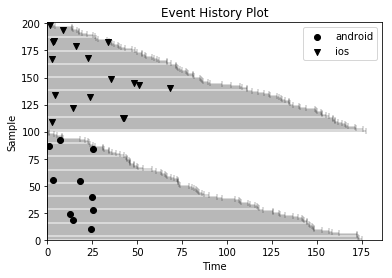

In [16]:
df_purchases = transform_data(data_purchases)
df_android = df_purchases[df_purchases['Platform'] == 'android']
df_ios = df_purchases[df_purchases['Platform'] == 'ios']

fig, ax = plt.subplots(1, 1)
plot_datas([('android', df_android), ('ios', df_ios)], ax=ax, alpha=0.2, plot_costs=False)

We save the data set to 'purchases_compare.csv'. The regression tutorial in R needs to know the time of previous purchase, so we add a column 'Time_prev':

In [17]:
data_purchases = data_purchases.copy()
data_purchases['Time_prev'] = data_purchases.groupby('Sample')['Time'].transform(lambda s: s.shift(1).fillna(0))
data_purchases[['Sample', 'Time', 'Time_prev', 'Event', 'Cost', 'Platform']].to_csv('tutorial/purchases_compare.csv', index=False)

<a id='data3'></a>

## Data set 3

In the third data set, we assume that the combination of different variables imply many different cohorts with different purchase rates. The cohorts are defined by a combination of two platforms (android, ios), four countries (GB, US, AU, NL), and three difficulty levels (easy, normal, hard). We take the cohort android/GB/normal as the baseline with $\lambda=0.004$ and $\mu=0.02$. Let the effect of different variables to the purchase rate $\lambda$ be as follows:
* platform: ios +50\%
* country: US +0\%, AU +100\%, NL -50\%
* difficulty: easy -5\%, hard -5\%.

In [18]:
to_string = lambda elements : ' / '.join(elements)

platforms = (('android', 1.0), ('ios', 1.5))
countries = (('GB', 1.0), ('US', 1.0), ('AU', 2.0), ('NL', 0.5))
difficulty = (('easy', 0.95), ('normal', 1.0), ('hard', 0.95))

datas = []
for k1, v1 in platforms:
    for k2, v2 in countries:
        for k3, v3 in difficulty:
            process = MarkovRecurrentTerminal(play_rate, purchase_rate*v1*v2*v3, churn_rate, playtime_dist, purchase_dist)
            data = process.Sample(50, max_date)
            data['Platform'] = k1
            data['Country'] = k2
            data['Difficulty'] = k3
            datas.append(data)
            print "Expected number of purchases %s %.2f" % (to_string([k1, k2, k3]), purchase_rate*v1*v2*v3/churn_rate)
datas = combine_datas(*datas)
data_purchases = datas[(datas['Type'] == 1) | (datas['Event'] == 0)]

Expected number of purchases android / GB / easy 0.19
Expected number of purchases android / GB / normal 0.20
Expected number of purchases android / GB / hard 0.19
Expected number of purchases android / US / easy 0.19
Expected number of purchases android / US / normal 0.20
Expected number of purchases android / US / hard 0.19
Expected number of purchases android / AU / easy 0.38
Expected number of purchases android / AU / normal 0.40
Expected number of purchases android / AU / hard 0.38
Expected number of purchases android / NL / easy 0.10
Expected number of purchases android / NL / normal 0.10
Expected number of purchases android / NL / hard 0.10
Expected number of purchases ios / GB / easy 0.29
Expected number of purchases ios / GB / normal 0.30
Expected number of purchases ios / GB / hard 0.29
Expected number of purchases ios / US / easy 0.29
Expected number of purchases ios / US / normal 0.30
Expected number of purchases ios / US / hard 0.29
Expected number of purchases ios / AU / 

There are now so many cohorts it is difficult to make sense of the data. In fact, we run out of markers with 24 different cohorts:

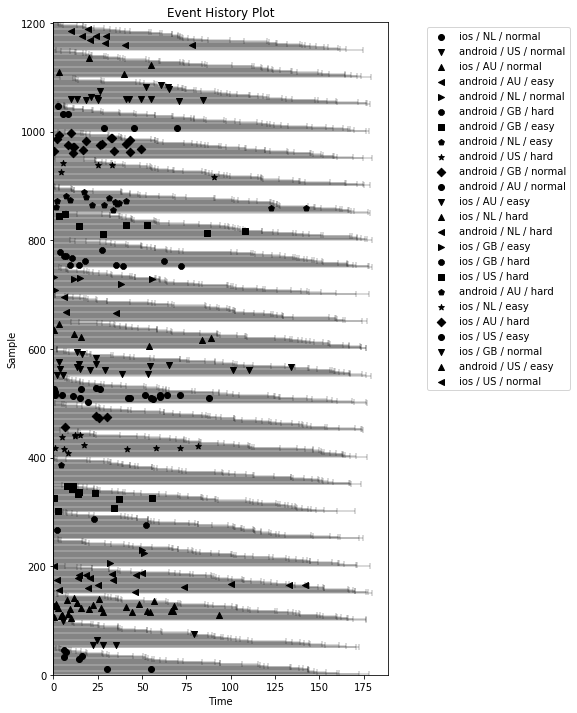

In [19]:
df_purchases = transform_data(data_purchases)
df_cohorts = {to_string(cohort): df for cohort, df in df_purchases.groupby(['Platform', 'Country', 'Difficulty'])}

fig, ax = plt.subplots(1, 1, figsize=(6,12))
plot_datas(df_cohorts.items(), ax=ax, alpha=0.2, plot_costs=False)
ax.legend(bbox_to_anchor=(1.1, 1.0))

We save the data set to 'purchases_regression.csv'. Again we add a column 'Time_prev' with the previous purchase time:

In [20]:
data_purchases = data_purchases.copy()
data_purchases['Time_prev'] = data_purchases.groupby('Sample')['Time'].transform(lambda s: s.shift(1).fillna(0))
data_purchases[['Sample', 'Time', 'Time_prev', 'Event', 'Cost', 'Platform', 'Country', 'Difficulty']].to_csv('tutorial/purchases_regression.csv', index=False)

<a id='data4'></a>

##  Data set 4

In the final data set, we assume that we have an old game version similar to the basic data set with $\lambda=0.004$ and $\mu=0.02$. However, a new version was launched and we want to analyze the data after only two months (60 days). The new version improved the game by increasing the purchase rate $\lambda$ by +50\%. Maybe this older data set could be used to extrapolate what eventually happens in the new data set?

In [21]:
process = MarkovRecurrentTerminal(play_rate, purchase_rate, churn_rate, playtime_dist, purchase_dist)
data1 = process.Sample(300, max_date)
data1['Version'] = 'old'

process =  MarkovRecurrentTerminal(play_rate, purchase_rate*1.5, churn_rate, playtime_dist, purchase_dist)
data2 = process.Sample(300/3, max_date/3)
data2['Version'] = 'new'

data = combine_datas(data1, data2)
data_purchases = data[(data['Type'] == 1) | (data['Event'] == 0)].copy()

print "Expected number of purchases old %.2f, new %.2f" % (purchase_rate/churn_rate, purchase_rate*1.5/churn_rate)

Expected number of purchases old 0.20, new 0.30


We plot the data set and see that the new version may have more purchases initially:

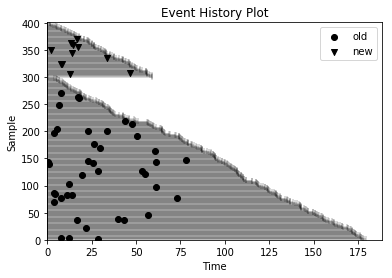

In [22]:
df_purchases = transform_data(data_purchases)

df_old = df_purchases[df_purchases['Version'] == 'old']
df_new = df_purchases[df_purchases['Version'] == 'new']

fig, ax = plt.subplots(1, 1)
plot_datas([('old', df_old), ('new', df_new)], ax=ax, plot_costs=False, alpha=0.2)

We save the data set to 'purchases_extrapolate.csv'. Again we add a column 'Time_prev' with the previous purchase time:

In [23]:
data_purchases = data_purchases.copy()
data_purchases['Time_prev'] = data_purchases.groupby('Sample')['Time'].transform(lambda s: s.shift(1).fillna(0))
data_purchases[['Sample', 'Time', 'Time_prev', 'Event', 'Cost', 'Version']].to_csv('tutorial/purchases_extrapolate.csv', index=False)

<a id='conclusion'></a>

## Conclusion

Thats it! 

In summary, we now have four data sets to analyze:
    
1. Data set: a simple population of 100 players with sessions (sessions.csv) and purchases (purchases.csv)
2. Data set: comparison of 100 ios players and 100 android players (purchases_compare.csv)
3. Data set: 24 different platform/country/difficulty cohorts with 50 players each (purchases_regression.csv)
4. Data set: comparison of new version with 300 players and old game version with 100 players (purchases_extrapolate.csv)
